In [31]:
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")

data_dir = "./data/dogs_emotions/"
print("Path to dataset files:", data_dir)

Path to dataset files: ./data/dogs_emotions/


Огляньте структуру датасету:
● визначте кількість класів (навчальна множина / тестова);
● виділіть валідаційну множину;
● структуру каталогів (папок);
● ознайомтеся з форматом файлів;
● виконайте перетворення в тензори;
● денормалізація (при необхідності);
● створіть DataLoader для навчального та тестового наборів даних, щоб
спростити процес завантаження даних за батчами;
● реалізуйте аугментацію даних для підвищення загальної якості моделі;
● проаналізуйте якість даних, перевірте на наявність зашумлень або
незбалансованих класів;
● візуалізуйте по декілька прикладів з різних класів;
● створіть графік (наприклад, гістограму), який відображає кількість
зображень в кожному класі. Ви можете використовувати бібліотеку matplotlib/seaborn
для візуалізації.

**dogs_emotions** directory contains 4 sub directory specifying the dog emotions in .jpg images accordingly:

1- angry directory containing images of angry dogs

2- happy directory containing images of happy dogs

3- relaxed directory containing images of relaxed dogs

4- sad directory containing images of sad dogs

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from collections import Counter
import os
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
from PIL import Image

In [33]:
image_sizes = {}
dataset_size = None

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('jpg')):
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                size = img.size
                if size in image_sizes:
                    image_sizes[size] += 1
                else:
                    image_sizes[size] = 1

for size, count in image_sizes.items():
    print(f"Розмір {size}: {count} зображень")
    dataset_size = count

Розмір (384, 384): 15921 зображень


In [111]:

full_dataset = torchvision.datasets.ImageFolder(root=data_dir)

class_names = full_dataset.classes
print("Класи: ", class_names)
print(full_dataset.class_to_idx)

Класи:  ['angry', 'happy', 'relaxed', 'sad']
{'angry': 0, 'happy': 1, 'relaxed': 2, 'sad': 3}


In [107]:
def dataset_statistics(dataset, classes, label):
    num_samples = len(dataset)
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    
    print(label)
    print("-----------------------------")
    print(f"🔹 Загальна кількість зображень: {num_samples}")
    print(f"🔹 Кількість класів: {len(classes)}")
    print("🔹 Список класів:")
    for i, cls in enumerate(classes):
        print(f"   {i}: {cls} ({label_counts[i]} зразків)")
    
    # Візуалізація розподілу класів
    plt.figure(figsize=(10, 5))
    plt.bar(classes, [label_counts[i] for i in range(len(classes))], color='skyblue')
    plt.xlabel("Класи")
    plt.ylabel("Кількість зразків")
    plt.title("Розподіл класів у наборі даних")
    plt.xticks(rotation=45)
    plt.show()


Огляд датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 15921
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (2256 зразків)
   1: happy (4784 зразків)
   2: relaxed (4349 зразків)
   3: sad (4532 зразків)


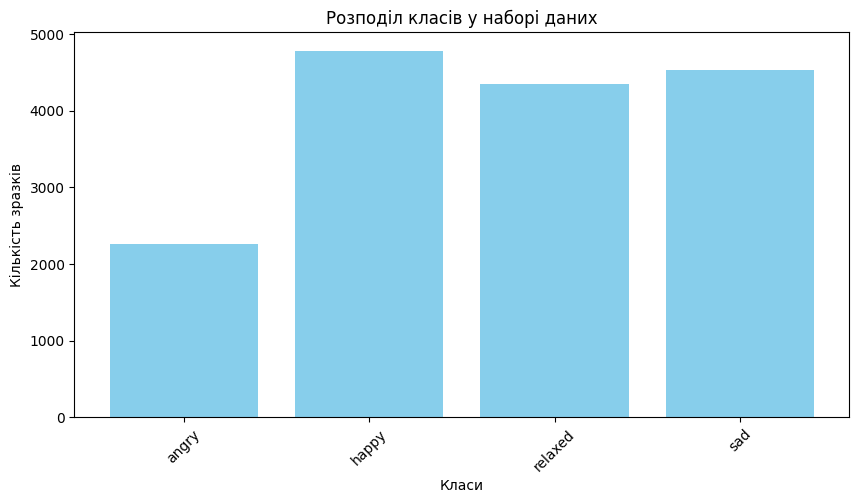

In [108]:
dataset_statistics(full_dataset, class_names, "Огляд датасету Dog Emotions")

Отже, як ми бачимо датасет незбалансований, що пізніше може ускладнити навчання класифікаційних моделей.

In [110]:
# Аугментації для збільшення кількості зображень у найменш представленому класі "angry"
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.2)),
    transforms.ToTensor()
])

def augment_and_save(image_path, output_dir, num_augmentations=1):
    """Функція для створення аугментованих версій зображення."""
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        for i in range(num_augmentations):
            augmented_img = augment_transform(img)
            augmented_img = transforms.ToPILImage()(augmented_img)
            new_filename = f"aug_{i}_{os.path.basename(image_path)}"
            augmented_img.save(os.path.join(output_dir, new_filename))

# Обробка всіх зображень у папці "angry" (подвоюємо їх кількість)
for filename in os.listdir(data_dir + "angry/"):
    if filename.endswith(('.jpg')):
        img_path = os.path.join(data_dir + "angry/", filename)
        augment_and_save(img_path, data_dir + "angry/aug/", num_augmentations=1)

print("Аугментація завершена! Нові зображення збережені в ", data_dir + "angry/aug/")


Аугментація завершена! Нові зображення збережені в  ./data/dogs_emotions/angry/aug/


Огляд датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 18177
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (4512 зразків)
   1: happy (4784 зразків)
   2: relaxed (4349 зразків)
   3: sad (4532 зразків)


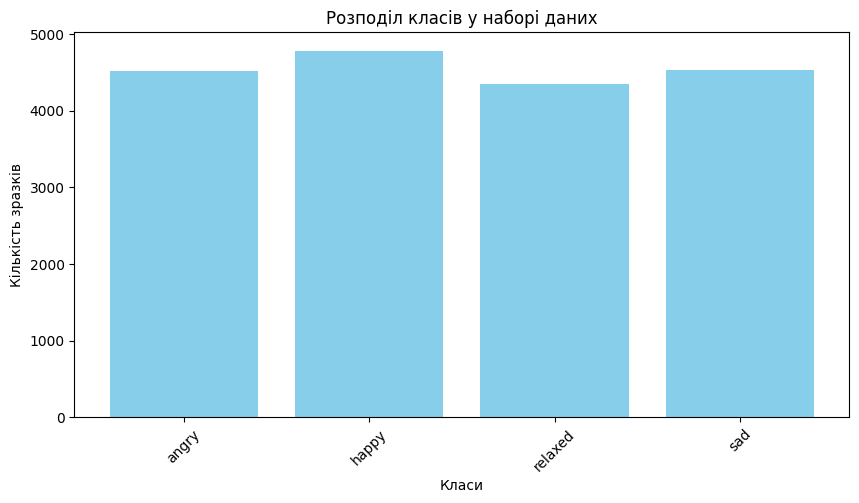

In [116]:
full_dataset = torchvision.datasets.ImageFolder(root=data_dir)
dataset_size = len(full_dataset)
dataset_statistics(full_dataset, class_names, "Огляд датасету Dog Emotions")

In [99]:
# Аналіз зашумлених зображень
noisy_images = []
for img_path, _ in full_dataset.imgs:
    with Image.open(img_path) as img:
        img_array = np.array(img)
        if len(img_array.shape) != 3 or img_array.shape[2] != 3:  # Перевірка, чи зображення має 3 канали (RGB)
            noisy_images.append(img_path)

print(f"Знайдено {len(noisy_images)} потенційно зашумлених або некоректних зображень.")
if noisy_images:
    print("Приклад зашумленого зображення:")
    img = Image.open(noisy_images[0])
    plt.imshow(img)
    plt.title("Зашумлене зображення")
    plt.axis("off")
    plt.show()

Знайдено 0 потенційно зашумлених або некоректних зображень.


In [117]:
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

In [118]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2)
    ])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [119]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [120]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [121]:
def show_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        img = images[i].numpy().transpose((1, 2, 0))
        img = (img * 0.5) + 0.5  # Денормалізація
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")
    plt.show()

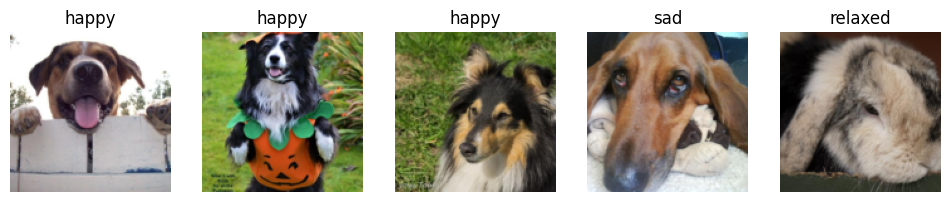

In [49]:
show_images(train_loader)

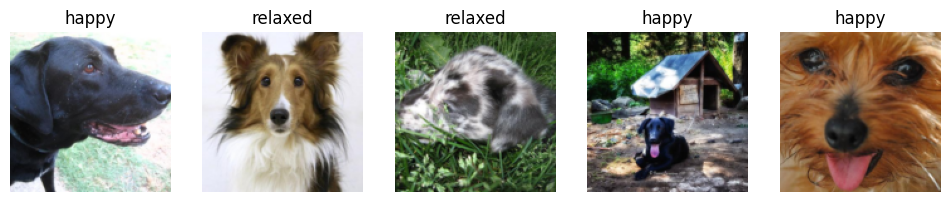

In [51]:
show_images(val_loader)

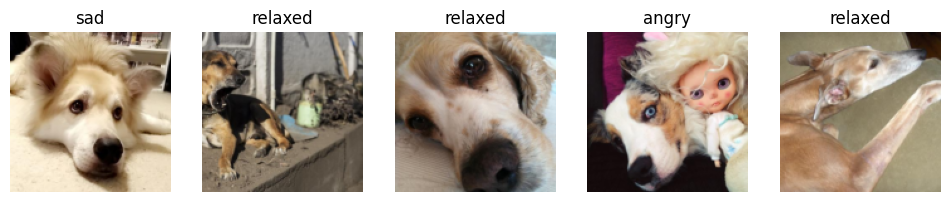

In [50]:
show_images(test_loader)

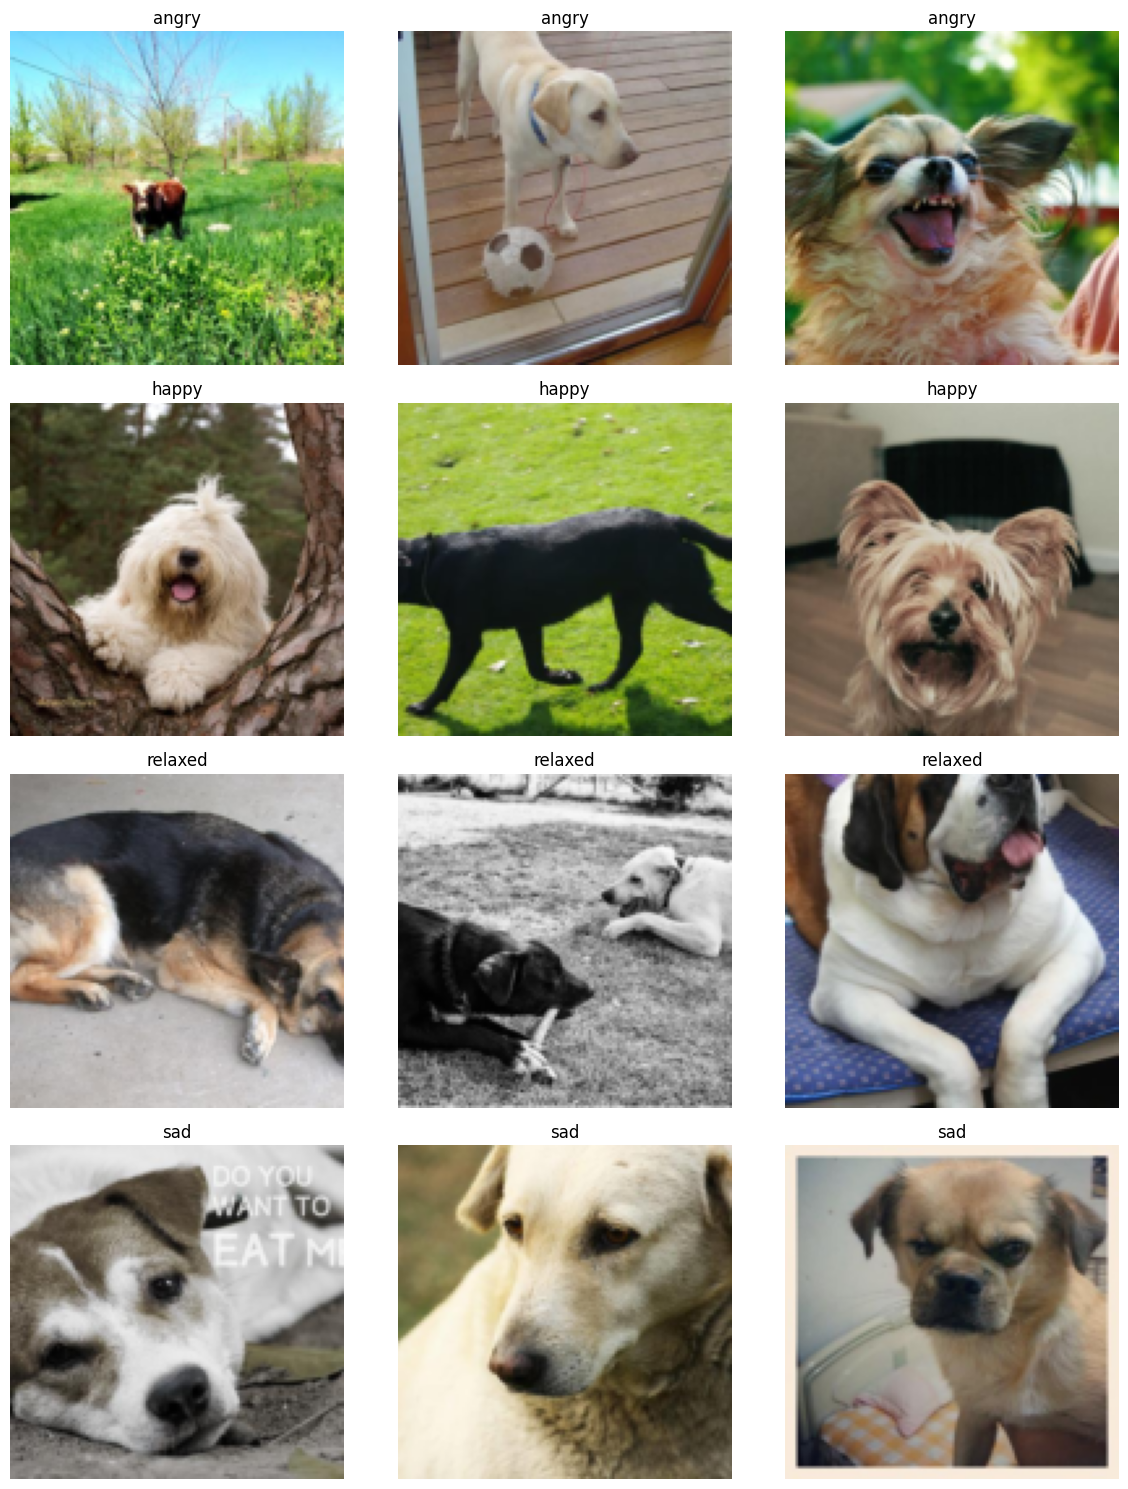

In [52]:
def get_random_images_by_class(train_dataset, classes, num_images_per_class=3):
    class_images = {cls: [] for cls in range(len(classes))}

    # Проходимо через датасет і зберігаємо зображення для кожного класу
    for img, label in train_dataset:
        if len(class_images[label]) < num_images_per_class:
            class_images[label].append(img)
        if all(len(v) == num_images_per_class for v in class_images.values()):
            break  # Вихід, якщо набрали потрібну кількість зображень

    # Візуалізація
    fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(12, 15))

    for class_idx, images in class_images.items():
        for i, img in enumerate(images):
            img = img.numpy().transpose((1, 2, 0))  # Перетворення для відображення
            img = img * 0.5 + 0.5  # Денормалізація
            
            ax = axes[class_idx, i] if num_images_per_class > 1 else axes[class_idx]
            ax.imshow(img)
            ax.set_title(classes[class_idx])
            ax.axis("off")

    plt.tight_layout()
    plt.show()

get_random_images_by_class(train_loader.dataset, class_names)

Огляд тренувального датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 12723
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (3143 зразків)
   1: happy (3369 зразків)
   2: relaxed (3055 зразків)
   3: sad (3156 зразків)


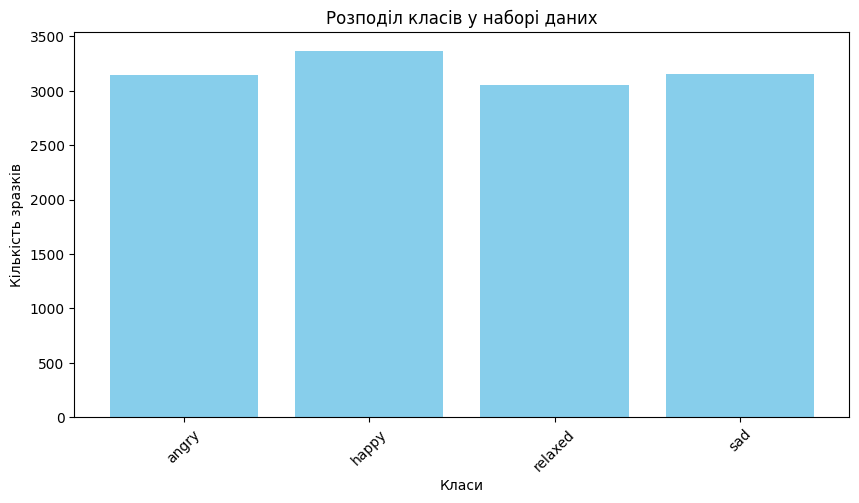

In [122]:
dataset_statistics(train_loader.dataset, class_names, "Огляд тренувального датасету Dog Emotions")

Огляд валідаційного датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 3635
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (914 зразків)
   1: happy (956 зразків)
   2: relaxed (866 зразків)
   3: sad (899 зразків)


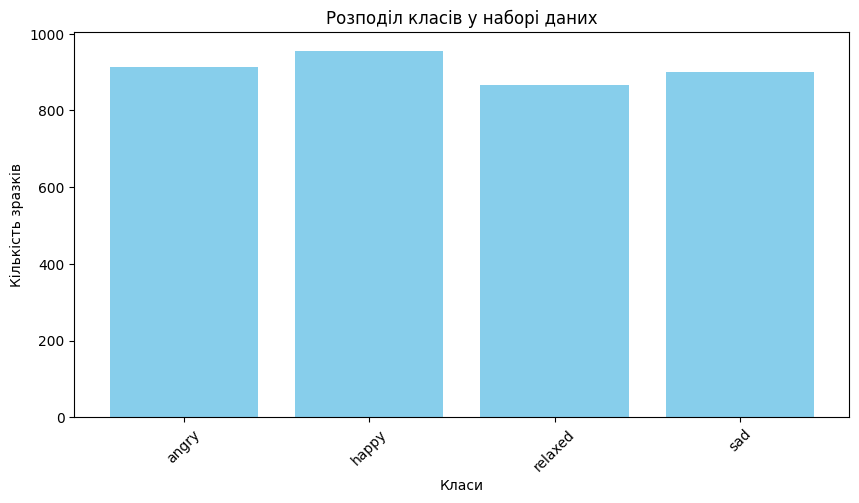

In [123]:
dataset_statistics(val_loader.dataset, class_names, "Огляд валідаційного датасету Dog Emotions")

Огляд тестувального датасету Dog Emotions
-----------------------------
🔹 Загальна кількість зображень: 1819
🔹 Кількість класів: 4
🔹 Список класів:
   0: angry (455 зразків)
   1: happy (459 зразків)
   2: relaxed (428 зразків)
   3: sad (477 зразків)


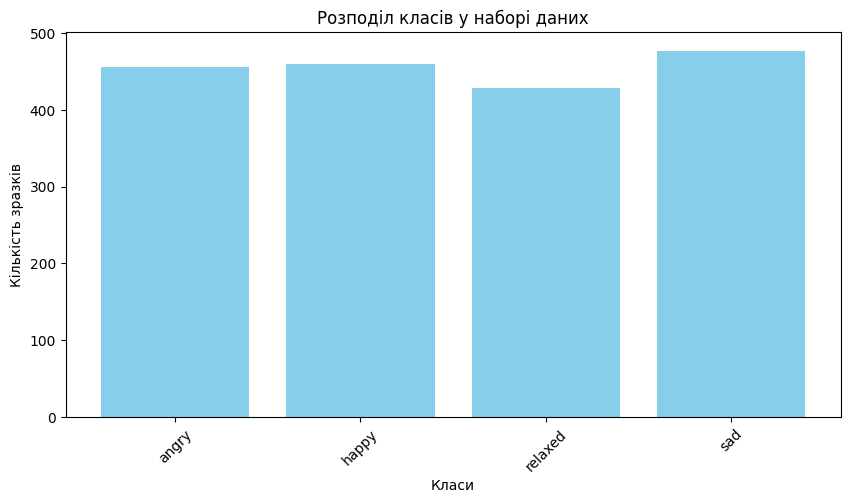

In [124]:
dataset_statistics(test_loader.dataset, class_names, "Огляд тестувального датасету Dog Emotions")

### **Планування на наступний етап**

#### **Метрики для оцінки ефективності**
- точність (Accuracy), частка правильних прогнозів
- F1-Score, комбінація precision and recall (especially in macro or weighted versions)


#### **Архітектура нейронної мережі**

- 3-4 згорткових шари

- ReLU активація для згорткових шарів, Softmax активація для вихідного шару

- 2-3 повнозв'язні шари

- оптимізатор Adam для адаптивного кроку навчання з weight_decay

- dropout 0.2-0.5 для запобігання перенавчанню